<a href="https://colab.research.google.com/github/ramalias/urban-expansion/blob/main/main-urban-expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#install library if needed

!pip install rasterio matplotlib numpy
!apt-get install -y gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [4]:
#import library

import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess

In [5]:
#create main project folder
#run one time only

project_root = '/content/drive/MyDrive/project/urban-exansion'
os.makedirs(project_root, exist_ok=True)

#create folder inside project folder
os.makedirs(os.path.join(project_root, 'data'), exist_ok=True)

print('Workspace created at:', project_root)

Workspace created at: /content/drive/MyDrive/project/urban-exansion


# Unzip the Data

In [6]:
dataset_base_dir = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'

files = {
    "2019": os.path.join(dataset_base_dir, "S2A_MSIL2A_20191216T021101_N0500_R103_T52SDE_20230616T061041.SAFE.zip"),
    "2024": os.path.join(dataset_base_dir, "S2A_MSIL2A_20241219T021111_N0511_R103_T52SDE_20241219T055658.SAFE.zip")
}

extracted_dir = os.path.join(dataset_base_dir, 'unzipped')
os.makedirs(extracted_dir, exist_ok=True)

In [7]:
for year, path in files.items():
    year_dir = os.path.join(extracted_dir, year)
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(year_dir)
    print(f"Extracted {year} data to: {year_dir}")

Extracted 2019 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019
Extracted 2024 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2024


In [8]:
def find_bands(year_dir):
    band_files = {}
    for band in ['B02', 'B03', 'B04', 'B08']:
        pattern = f"{year_dir}/**/*{band}_10m.jp2"
        matches = glob.glob(pattern, recursive=True)
        if matches:
            band_files[band] = matches[0]
    return band_files

bands_2019 = find_bands(os.path.join(extracted_dir, "2019"))
bands_2024 = find_bands(os.path.join(extracted_dir, "2024"))

print("2019 Bands:", bands_2019)
print("2024 Bands:", bands_2024)

2019 Bands: {'B02': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2A_MSIL2A_20191216T021101_N0500_R103_T52SDE_20230616T061041.SAFE/GRANULE/L2A_T52SDE_A023409_20191216T021102/IMG_DATA/R10m/T52SDE_20191216T021101_B02_10m.jp2', 'B03': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2A_MSIL2A_20191216T021101_N0500_R103_T52SDE_20230616T061041.SAFE/GRANULE/L2A_T52SDE_A023409_20191216T021102/IMG_DATA/R10m/T52SDE_20191216T021101_B03_10m.jp2', 'B04': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2A_MSIL2A_20191216T021101_N0500_R103_T52SDE_20230616T061041.SAFE/GRANULE/L2A_T52SDE_A023409_20191216T021102/IMG_DATA/R10m/T52SDE_20191216T021101_B04_10m.jp2', 'B08': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2A_MSIL2A_20191216T021101_N0500_R103_T52SDE_20230616T061041.SAFE/GRANULE/L2A_T52SDE_A023409_20191216T021102/IMG_DATA/R10m/T52SDE_20191

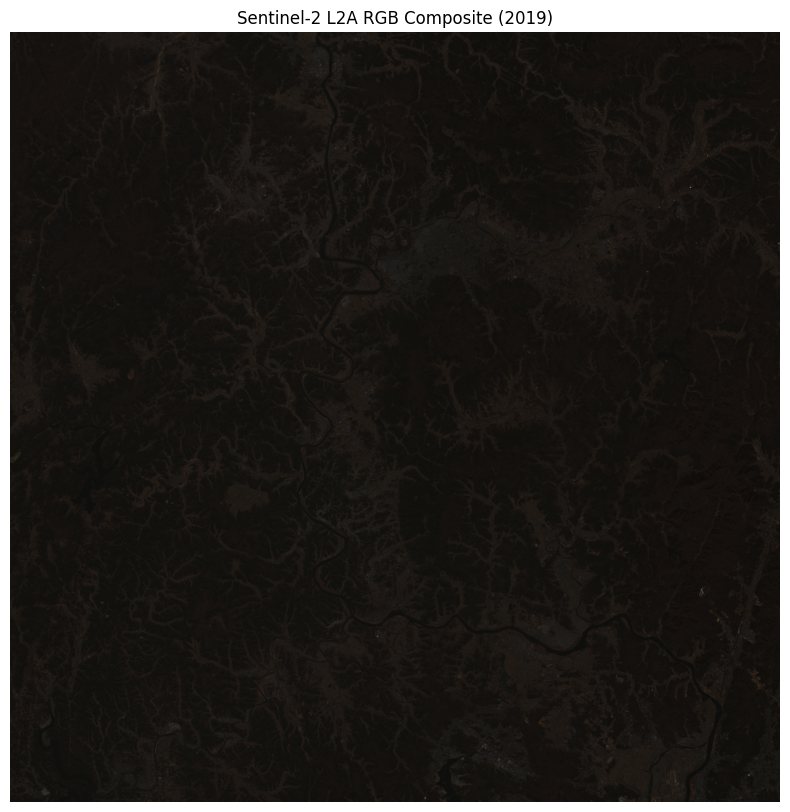

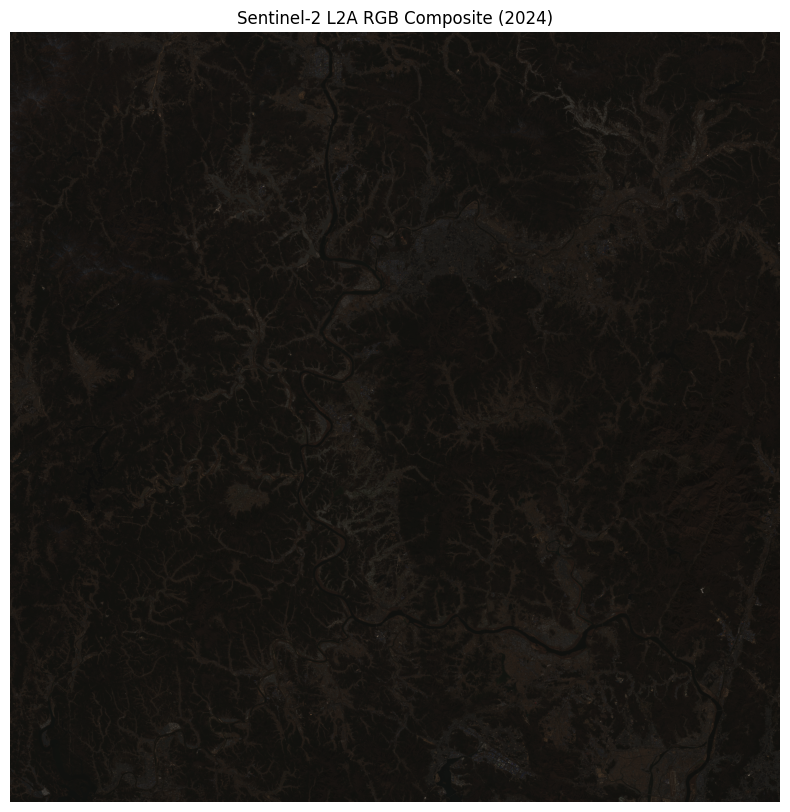

In [9]:
def show_rgb(band_paths, title):
    with rasterio.open(band_paths['B04']) as red:
        r = red.read(1)
    with rasterio.open(band_paths['B03']) as green:
        g = green.read(1)
    with rasterio.open(band_paths['B02']) as blue:
        b = blue.read(1)

    def normalize(band):
        return (band - band.min()) / (band.max() - band.min())

    rgb = np.dstack([normalize(r), normalize(g), normalize(b)])

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_rgb(bands_2019, "Sentinel-2 L2A RGB Composite (2019)")

show_rgb(bands_2024, "Sentinel-2 L2A RGB Composite (2024)")

In [16]:
# === Sentinel input folders ===
sentinel_2019 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/S2A_MSIL2A_20191216T021101'
sentinel_2024 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/S2A_MSIL2A_20241219T021111'

# === Output folders ===
output_base = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'
output_2019 = os.path.join(output_base, 'tiff2019')
output_2024 = os.path.join(output_base, 'tiff2024')
os.makedirs(output_2019, exist_ok=True)
os.makedirs(output_2024, exist_ok=True)

# === Bands to extract ===
targets = ["B02", "B03", "B04", "B08", "B11"]

# === Helper function ===
def convert_sentinel_data(input_dir, output_dir, year):
    print(f"Processing {year} data...")
    for b in targets:
        # search recursively inside all subfolders (including IMG_DATA)
        pattern = os.path.join(input_dir, "**", f"*{b}*.jp2")
        src_files = sorted(glob.glob(pattern, recursive=True))

        if not src_files:
            print(f"No file found for band {b} in {year}")
            continue

        for src in src_files:
            # Keep relative path to prevent filename conflicts
            rel_path = os.path.relpath(src, input_dir).replace("/", "_")
            dst_name = rel_path.replace(".jp2", ".tif")
            dst = os.path.join(output_dir, dst_name)

            cmd = [
                "gdal_translate", "-of", "COG",
                "-co", "COMPRESS=LZW", "-co", "NUM_THREADS=ALL_CPUS",
                src, dst
            ]
            print(f"Converting [{year}] → {os.path.basename(src)}")
            subprocess.run(cmd, check=True)

    print(f"Finished converting {year}. Files saved in: {output_dir}")

# === Run conversion for both years ===
convert_sentinel_data(sentinel_2019, output_2019, 2019)
convert_sentinel_data(sentinel_2024, output_2024, 2024)

print("All conversions complete!")


Processing 2019 data...
Converting [2019] → T52SDE_20191216T021101_B02_10m.jp2
Converting [2019] → T52SDE_20191216T021101_B02_20m.jp2
Converting [2019] → T52SDE_20191216T021101_B02_60m.jp2
Converting [2019] → T52SDE_20191216T021101_B03_10m.jp2
Converting [2019] → T52SDE_20191216T021101_B03_20m.jp2
Converting [2019] → T52SDE_20191216T021101_B03_60m.jp2
Converting [2019] → T52SDE_20191216T021101_B04_20m.jp2
Converting [2019] → T52SDE_20191216T021101_B04_60m.jp2
No file found for band B08 in 2019
Converting [2019] → T52SDE_20191216T021101_B11_20m.jp2
Converting [2019] → T52SDE_20191216T021101_B11_60m.jp2
Finished converting 2019. Files saved in: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tiff2019

Processing 2024 data...
Converting [2024] → T52SDE_20241219T021111_B02_10m.jp2
Converting [2024] → T52SDE_20241219T021111_B02_20m.jp2
Converting [2024] → T52SDE_20241219T021111_B02_60m.jp2
Converting [2024] → T52SDE_20241219T021111_B03_10m.jp2
Converting [2024] → T52S